<a href="https://colab.research.google.com/github/reshalfahsi/instance-segmentation-vit-maskrcnn/blob/master/Instance_Segmentation_Using_ViT_based_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instance Segmentation Using ViT-based Mask R-CNN**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 192.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 194.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 175.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 139.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 156.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 79.9 MB/s eta 0:00:00
     ━━

### **Import**

In [2]:
import os
import re
import io
import cv2
import math
import time
import random
import shutil
import errno
import tarfile
import logging
import warnings
import collections

import numpy as np
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import hashlib
import requests

from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torchvision.datasets.utils import download_and_extract_archive
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models.detection import (
    maskrcnn_resnet50_fpn_v2,
    MaskRCNN_ResNet50_FPN_V2_Weights
)
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops.feature_pyramid_network import (
    LastLevelMaxPool,
    FeaturePyramidNetwork
)
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as FT
from torchvision.transforms import v2 as T

try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.detection.mean_ap import MeanAveragePrecision

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [4]:
NUM_LAYER = 12
PATCH_SIZE = 16
HIDDEN_DIM = 768
NUM_CLASSES = 2
IMG_SIZE = 224
INFERENCE_SAMPLE = 3
THRESHOLD_DETECTION = 0.75
THRESHOLD_SEGMENTATION = 0.5

In [5]:
MAX_EPOCH               = 317
BATCH_SIZE              = 17
EARLY_STOPPING_PATIENCE = 31

In [6]:
LEARNING_RATE    = 1 / 62.8318 * (math.pi / math.e)
MOMENTUM         = 1 / 9.41149 * (math.pi * math.e)
WEIGHT_DECAY     = 1 / 12345.6 * (math.pi + math.e)
REDUCE_LR_FACTOR = 1 / 0.56789 * (math.pi - math.e)

In [7]:
MILESTONES = 1. / math.sqrt(MAX_EPOCH) * (
    np.array(
        [m for m in range(1, int(math.sqrt(MAX_EPOCH)))]
    )
)

In [8]:
METRIC_TO_MONITOR = "val_loss"
METRIC_MODE       = "min"

In [9]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1178986302


## **Dataset**

### **Prepare**

In [10]:
dataset_filename = "PennFudanPed.zip"
download_and_extract_archive(
    f"https://www.cis.upenn.edu/~jshi/ped_html/{dataset_filename}",
    "experiment/dataset",
    filename=dataset_filename,
)
os.remove(os.path.join("experiment/dataset", dataset_filename))

100%|██████████| 53723336/53723336 [00:01<00:00, 28558834.51it/s]


Extracting experiment/dataset/PennFudanPed.zip to experiment/dataset


### **Utils**

In [11]:
def get_transform(split):
    transforms = []
    if split == "train":
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [12]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, split, root="experiment/dataset/PennFudanPed", transforms=get_transform):
        self.root = root
        self.transforms = transforms(split)
        # load all image files, sorting them to
        # ensure that they are aligned
        random.seed(SEED)
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        random.shuffle(self.imgs)
        random.seed(SEED)
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        random.shuffle(self.masks)

        num_img = len(self.imgs)
        if split == "train":
            start = 0
            end = int(0.8 * num_img)
        elif split == "val":
            start = int(0.8 * num_img)
            end = int(0.9 * num_img)
        elif split in ["test", "inference"]:
            start = int(0.9 * num_img)
            end = num_img

        self.split = split

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)

        if self.split == "inference":
            raw_img = img.detach().clone()

        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(
            boxes, format="XYXY", canvas_size=FT.get_size(img)
        )
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        if self.split == "inference":
            return raw_img, img

        return img, target

    def __len__(self):
        return len(self.imgs)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

### **Load**

In [14]:
TrainDataset = PennFudanDataset('train')
ValDataset = PennFudanDataset('val')
TestDataset = PennFudanDataset('test')

## **Model**

### **Utils**

In [15]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Module**

In [16]:
class IntermediateLayerGetter(nn.ModuleDict):
    _version = 2
    __annotations__ = {
        "return_layers",
    }

    def __init__(self, model, return_layers):
        if not set(return_layers).issubset(
            [name for name, _ in model.named_children()]
        ):
            raise ValueError("return_layers are not present in model")
        orig_return_layers = return_layers
        return_layers = {str(k): str(v) for k, v in return_layers.items()}
        layers = collections.OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super().__init__(layers)
        self.return_layers = orig_return_layers

        self.C = HIDDEN_DIM
        self.H = self.W = IMG_SIZE // PATCH_SIZE

    def forward(self, x):
        out = collections.OrderedDict()
        idx = 0
        for name, module in self.items():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                N = x.shape[0]
                out[out_name] = F.interpolate(
                    F.instance_norm(
                        x.permute(0, 2, 1).reshape(N, self.C, self.H, self.W)
                    ),
                    scale_factor=4 / (2**idx),
                    mode="bilinear",
                )
                idx += 1
        return out

In [17]:
class BackboneWithFPN(nn.Module):
    def __init__(
        self,
        backbone,
        return_layers,
        in_channels_list,
        out_channels,
        extra_blocks=None,
        norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.backbone = backbone

        self.body = IntermediateLayerGetter(
            self.backbone.encoder.layers,
            return_layers=return_layers,
        )
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x):
        x = self.backbone._process_input(x)
        x = x + self.backbone.encoder.pos_embedding
        x = self.backbone.encoder.dropout(x)
        x = self.body(x)
        x = self.fpn(x)
        return x

### **Wrappper**

In [18]:
class ViTMaskRCNN(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.lr = LEARNING_RATE
        self.max_epoch = MAX_EPOCH
        self.lr_now = self.lr * 1e3

        self.backbone = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.backbone.encoder.pos_embedding = torch.nn.Parameter(
            self.backbone.encoder.pos_embedding[:, 1:, :]
        )
        del self.backbone.class_token, self.backbone.encoder.ln
        self.backbone = BackboneWithFPN(
            self.backbone,
            {
                f"encoder_layer_{(NUM_LAYER - 1) - l}": str(
                    ((NUM_LAYER - 1) - l - 2) // 3
                )
                for l in range(9, -1, -3)
            },
            [HIDDEN_DIM] * 4,
            256,
        )

        self.mask_rcnn = maskrcnn_resnet50_fpn_v2(
            weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
        )
        self.mask_rcnn.backbone = self.backbone
        self.mask_rcnn.transform.min_size = [IMG_SIZE]
        self.mask_rcnn.transform.max_size = IMG_SIZE
        self.mask_rcnn.transform.fixed_size = (IMG_SIZE, IMG_SIZE)
        self.mask_rcnn.num_classes = NUM_CLASSES
        self.mask_rcnn.roi_heads.box_predictor.cls_score = nn.Linear(
            1024,
            NUM_CLASSES,
        )
        self.mask_rcnn.roi_heads.box_predictor.bbox_pred = nn.Linear(
            1024,
            4 * NUM_CLASSES,
        )

        self.test_mAP_box = MeanAveragePrecision(
            box_format="xyxy",
            iou_type="bbox",
        )
        self.test_mAP_seg = MeanAveragePrecision(
            iou_type="segm",
        )

        self.automatic_optimization = False

        self.train_loss = list()
        self.val_loss = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x, y=None):
        return self.mask_rcnn(x, y)

    def training_step(self, batch, batch_nb):
        x, y = batch
        x = list(image.to(self.device) for image in x)
        y = [
            {
                k: v.to(self.device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in y
        ]
        loss = self(x, y)
        loss = sum(l for l in loss.values())

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)

        self.train_loss_recorder.update(loss.data)

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()

        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        x = list(image.to(self.device) for image in x)
        y = [
            {
                k: v.to(self.device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in y
        ]
        self.mask_rcnn.train()
        loss = self(x, y)
        loss = sum(l for l in loss.values()).detach()

        if self.sanity_check_counter == 0:
            self.log("val_loss", loss, prog_bar=True)
            self.val_loss_recorder.update(loss.data)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            loss = self.val_loss_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                str_report = f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_}"
                str_report += f"- Epoch: {self.current_epoch}"
                print(str_report)
            self.val_loss.append(loss)
            self.val_loss_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        x = list(image.to(self.device) for image in x)
        y = [
            {
                k: v.to(self.device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in y
        ]
        y_hat = self(x)

        pred_box = list()
        target_box = list()

        pred_seg = list()
        target_seg = list()

        for b in range(len(y_hat)):
            try:
                pred_box.append(
                    dict(
                        boxes=y_hat[b]["boxes"],
                        scores=y_hat[b]["scores"],
                        labels=y_hat[b]["labels"].int(),
                    )
                )
            except:
                pred_box.append(
                    dict(
                        boxes=torch.tensor(
                            [[0.0, 0.0, 0.0, 0.0]],
                        ).to(self.device),
                        scores=torch.tensor([0.0]).to(self.device),
                        labels=torch.tensor([0.0]).to(self.device).int(),
                    )
                )

            try:
                pred_seg.append(
                    dict(
                        masks=(y_hat[b]["masks"] > THRESHOLD_SEGMENTATION)
                        .squeeze(1)
                        .to(torch.bool),
                        scores=y_hat[b]["scores"],
                        labels=y_hat[b]["labels"].int(),
                    )
                )
            except:
                pred_seg.append(
                    dict(
                        masks=torch.zeros(1, x[b].shape[-2], x[b].shape[-1])
                        .to(torch.bool)
                        .to(self.device),
                        scores=torch.tensor([0.0]).to(self.device),
                        labels=torch.tensor([0.0]).to(self.device).int(),
                    )
                )

            target_box.append(
                dict(
                    boxes=y[b]["boxes"],
                    labels=y[b]["labels"].int(),
                )
            )

            target_seg.append(
                dict(
                    masks=(y[b]["masks"] > THRESHOLD_SEGMENTATION)
                    .squeeze(1)
                    .to(torch.bool),
                    labels=y[b]["labels"].int(),
                )
            )

        self.test_mAP_box.update(pred_box, target_box)
        mAP_box = self.test_mAP_box.compute()["map"].data.detach().cpu()

        self.test_mAP_seg.update(pred_seg, target_seg)
        mAP_seg = self.test_mAP_seg.compute()["map"].data.detach().cpu()

        self.log("[BOX]_test_mAP@0.5:0.95", mAP_box, prog_bar=True, logger=True)
        self.log("[SEG]_test_mAP@0.5:0.95", mAP_seg, prog_bar=True, logger=True)

    def on_train_end(self):

        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

    def train_dataloader(self):
        return data.DataLoader(
            TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
            persistent_workers=True,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            nesterov=True,
        )

        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[int(self.max_epoch * ms) for ms in MILESTONES],
                gamma=REDUCE_LR_FACTOR,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [19]:
MODEL_NAME = ViTMaskRCNN.__name__
MODEL = ViTMaskRCNN
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 1178986302
INFO:lightning.fabric.utilities.seed:Seed set to 1178986302


ViTMaskRCNN


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 65.6MB/s]
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:02<00:00, 78.1MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:L

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.01839398759530877- Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.01371106035748983- Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.010220360058015653- Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.007618357515173617- Epoch: 53


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.00567879907356914- Epoch: 71


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.004233033019747276- Epoch: 89


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0031553446977318164- Epoch: 106


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0023520251590427475- Epoch: 124


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0017532228262562544- Epoch: 142


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0013068696423965858- Epoch: 160


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0009741535625935029- Epoch: 178


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0007261437045651684- Epoch: 195


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.000541274702394794- Epoch: 213


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.00040347151894405664- Epoch: 231


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.00030075166247154353- Epoch: 249


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.0002241832650694207- Epoch: 267


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ViTMaskRCNN] Learning Rate Changed: 0.00016710842402057032- Epoch: 284


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=317` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=317` reached.


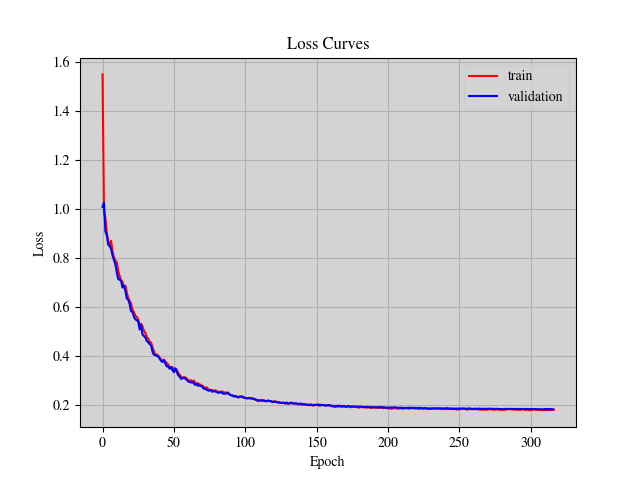

<Figure size 640x480 with 0 Axes>

In [20]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=EARLY_STOPPING_PATIENCE,
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [21]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/ViTMaskRCNN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/ViTMaskRCNN_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/ViTMaskRCNN_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  [BOX]_test_mAP@0.5:0.95  │    0.9685114622116089     │
│  [SEG]_test_mAP@0.5:0.95  │    0.7958204746246338     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Utils**

In [22]:
def _generate_color_palette():
    palette = torch.randn(3)
    palette = (0.5 * ((palette / torch.norm(palette)) + 1) * 255).long()
    return tuple(palette)

### **Initialize**

In [23]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

InferenceDataset = PennFudanDataset('inference')
InferenceLoader = data.DataLoader(
    InferenceDataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    persistent_workers=True,
)

### **Result**

In [ ]:
for batch in InferenceLoader:

    image, x = batch

    image = image[0]
    x = list(img.to("cuda" if torch.cuda.is_available() else "cpu") for img in x)

    try:
        output = model(x)[0]
    except:
        continue

    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(
        torch.uint8
    )
    image = image[:3, ...]

    pred_labels = list()
    pred_boxes = list()
    pred_masks = list()

    idx = 0

    for label, score in zip(output["labels"], output["scores"]):
        if label and score > THRESHOLD_DETECTION:
            pred_labels.append(f"pedestrian: {score:.3f}")
            pred_boxes.append(output["boxes"][idx].long().unsqueeze(0))
            pred_masks.append(output["masks"][idx].unsqueeze(0))
        idx += 1

    pred_boxes = torch.cat(pred_boxes, 0)
    pred_masks = torch.cat(pred_masks, 0)
    pred_masks = (pred_masks > THRESHOLD_SEGMENTATION).squeeze(1)

    colors = [_generate_color_palette() for _ in range(pred_boxes.shape[0])]

    output_image = draw_bounding_boxes(
        image, pred_boxes, pred_labels, colors=colors
    )
    output_image = draw_segmentation_masks(
        output_image, pred_masks, alpha=0.7, colors=colors
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(output_image.permute(1, 2, 0))
    plt.axis("off")
    plt.show()